<a href="https://colab.research.google.com/github/sagewoodard/CIS731_DataScience_TermProject/blob/main/GEE_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.1 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import ee  # Google Earth Engine for satellite data processing
from google.colab import drive  # Mount Google Drive for file storage
import os  # File handling utilities
import rasterio  # For reading and manipulating GeoTIFF files
import numpy as np  # Numerical operations and array manipulation
from sklearn.model_selection import train_test_split  # Split data into training, validation, and test sets
import tensorflow as tf  # TensorFlow framework for deep learning
from tensorflow.keras import layers, models  # TensorFlow components for CNN
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout  # U-Net layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Evaluation metrics
import matplotlib.pyplot as plt  # Visualization library
import pickle  # Save and load data batches

# Authenticate and initialize Google Earth Engine
ee.Authenticate()  # Prompts user to authenticate their Earth Engine account
ee.Initialize(project='satellite-data-442019')  # Initialize Earth Engine API with the specified project

# Mount Google Drive to access exported data
drive.mount('/content/drive')  # Mounts Google Drive for seamless file access

Mounted at /content/drive


In [3]:
# Define the Iceland volcanic region and timeframe
region = ee.Geometry.Rectangle([-25.0, 63.0, -13.0, 67.0])  # Define bounding box for the Iceland region
start_date = '2018-01-01'  # Start date for filtering images
end_date = '2023-12-31'  # End date for filtering images

# Use the Sentinel-2 harmonized dataset and filter by cloud cover
dataset = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(region) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])  # Common bands

# Mosaic and clip the dataset
mosaic = dataset.mosaic().clip(region).uint16()  # Combine and clip images to the region, convert to 16-bit integers

# Export the data to Google Drive
task = ee.batch.Export.image.toDrive(
    image=mosaic,  # The image to export
    description='Iceland_Volcanic_Region',  # Description for the export task
    folder='EarthEngineExports_Iceland',  # Destination folder in Google Drive
    fileNamePrefix='Iceland_S2_SR',  # Prefix for the exported file name
    scale=30,  # Spatial resolution in meters
    region=region.getInfo()['coordinates'],  # Geographic region for the export
    fileFormat='GeoTIFF',  # Export format
    maxPixels=1e9  # Maximum number of pixels allowed
)
task.start()  # Start the export task
print('Export started. Monitor progress in the Google Earth Engine Task Manager.')  # Notify user of export status

Export started. Monitor progress in the Google Earth Engine Task Manager.


In [5]:
import folium

# Define a region of interest (ROI)
roi = ee.Geometry.Rectangle([-24.5, 63.3, -13.0, 66.3])

# Load Sentinel-2 data and create a cloud-free composite
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(roi) \
    .filterDate('2018-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

composite = sentinel2.median()  # Create a median composite

# Define visualization parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB bands
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Create a Folium map
gee_map = folium.Map(location=[64.0, -19.0], zoom_start=6)

# Function to add Earth Engine layers to Folium
def add_ee_layer(map_object, ee_object, vis_params, name):
    map_object.add_child(folium.TileLayer(
        tiles=ee_object.getMapId(vis_params)['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True
    ))

# Add the composite image to the map
add_ee_layer(gee_map, composite, vis_params, "Sentinel-2 Composite")

# Add a layer control panel
gee_map.add_child(folium.LayerControl())

# Display the map
gee_map

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


In [6]:
# Define the folder containing TIFF files
tiff_folder = '/content/drive/MyDrive/EarthEngineExports_Iceland/'  # Folder with exported GeoTIFFs

# Define the folder to save processed patches
output_folder = '/content/drive/MyDrive/Iceland_Patches/'  # Destination for patches
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't already exist

# List all TIFF files
tiff_files = [os.path.join(tiff_folder, f) for f in os.listdir(tiff_folder) if f.endswith('.tif')]  # List all GeoTIFF files

if not tiff_files:  # Check if any TIFF files are found
    raise FileNotFoundError("No TIFF files found in the specified directory.")  # Raise an error if none are found

print(f"Found {len(tiff_files)} TIFF files.")  # Print the number of found TIFF files

# Initialize patch counter
batch_counter = 0  # Counter to track the number of patches created

# Process each TIFF file
for tiff_file in tiff_files:  # Loop through all TIFF files
    print(f"Processing file: {tiff_file}")  # Log the file being processed
    with rasterio.open(tiff_file) as src:  # Open the TIFF file
        image_data = src.read() / 3000.0  # Normalize pixel values to the range [0, 1]
        print(f"Image shape (bands, height, width): {image_data.shape}")  # Log the image shape

        patch_size = 256  # Define the size of each patch
        for i in range(0, image_data.shape[1], patch_size):  # Loop through rows with stride equal to patch size
            for j in range(0, image_data.shape[2], patch_size):  # Loop through columns with stride equal to patch size
                patch = image_data[:, i:i+patch_size, j:j+patch_size]  # Extract a patch
                if patch.shape[1] == patch_size and patch.shape[2] == patch_size:  # Ensure patch is the correct size
                    # Save each patch and label
                    batch_file = os.path.join(output_folder, f'patch_{batch_counter}.pkl')  # Generate patch file path
                    with open(batch_file, 'wb') as f:  # Open file in write-binary mode
                        label = np.random.randint(0, 3)  # Generate a random label (0, 1, or 2)
                        pickle.dump({'patch': patch, 'label': label}, f)  # Save patch and label as a dictionary
                    batch_counter += 1  # Increment the patch counter

print(f"Total patches processed: {batch_counter}")  # Log the total number of patches created

Found 8 TIFF files.
Processing file: /content/drive/MyDrive/EarthEngineExports_Iceland/Iceland_S2_SR-0000000000-0000000000.tif
Image shape (bands, height, width): (12, 13568, 13568)
Processing file: /content/drive/MyDrive/EarthEngineExports_Iceland/Iceland_S2_SR-0000000000-0000013568.tif
Image shape (bands, height, width): (12, 13568, 13568)
Processing file: /content/drive/MyDrive/EarthEngineExports_Iceland/Iceland_S2_SR-0000000000-0000027136.tif
Image shape (bands, height, width): (12, 13568, 13568)
Processing file: /content/drive/MyDrive/EarthEngineExports_Iceland/Iceland_S2_SR-0000000000-0000040704.tif
Image shape (bands, height, width): (12, 13568, 3825)
Processing file: /content/drive/MyDrive/EarthEngineExports_Iceland/Iceland_S2_SR-0000013568-0000000000.tif
Image shape (bands, height, width): (12, 1695, 13568)
Processing file: /content/drive/MyDrive/EarthEngineExports_Iceland/Iceland_S2_SR-0000013568-0000013568.tif
Image shape (bands, height, width): (12, 1695, 13568)
Processing 

In [7]:
# List all patch files
patch_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.pkl')]  # List all patch files

if not patch_files:  # Check if patch files are found
    raise FileNotFoundError("No patch files found in the specified directory.")  # Raise an error if none are found

print(f"Found {len(patch_files)} patch files.")  # Log the number of patch files found

# Prepare data for training
patches = []  # Initialize an empty list for patches
labels = []  # Initialize an empty list for labels

for patch_file in patch_files[:1000]:  # Load only the first 1000 patches for demonstration
    with open(patch_file, 'rb') as f:  # Open patch file in read-binary mode
        data = pickle.load(f)  # Load the patch and label
        patches.append(data['patch'])  # Append the patch to the list
        labels.append(data['label'])  # Append the label to the list

# Convert to NumPy arrays
patches = np.array(patches)  # Convert patches list to a NumPy array
labels = np.array(labels)  # Convert labels list to a NumPy array

print(f"Loaded patches: {patches.shape}, labels: {labels.shape}")  # Log the shapes of the data arrays

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(patches, labels, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")  # Log data split info

Found 10207 patch files.
Loaded patches: (1000, 12, 256, 256), labels: (1000,)
Training set: (700, 12, 256, 256), Validation set: (150, 12, 256, 256), Test set: (150, 12, 256, 256)


Logistic Regression Test Accuracy: 0.37333333333333335


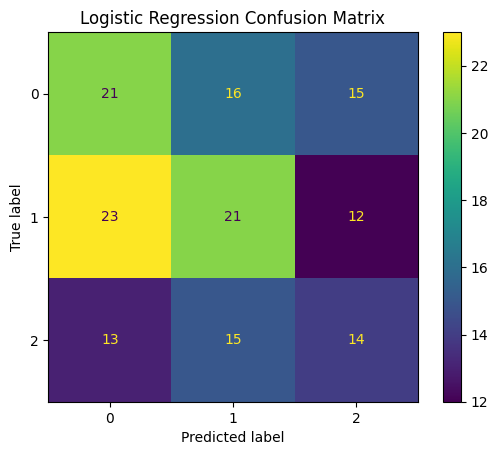

In [8]:
# ***Logistic Regression***

# Import Logistic Regression model and metrics
from sklearn.linear_model import LogisticRegression  # Baseline classification model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay  # Evaluation metrics

# Flatten the data for Logistic Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten training data to 2D (samples, features)
X_val_flat = X_val.reshape(X_val.shape[0], -1)  # Flatten validation data
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten test data

# Train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=500)  # Initialize the Logistic Regression model with max iterations
logistic_model.fit(X_train_flat, y_train)  # Fit the model to the training data

# Predict on the test set
y_pred = logistic_model.predict(X_test_flat)  # Generate predictions for the test data

# Evaluate the Logistic Regression model
logistic_test_accuracy = accuracy_score(y_test, y_pred)  # Calculate test accuracy
print(f"Logistic Regression Test Accuracy: {logistic_test_accuracy}")  # Log test accuracy

# Confusion Matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=[0, 1, 2])  # Initialize display
disp_logistic.plot(cmap='viridis')  # Plot confusion matrix with color map
plt.title("Logistic Regression Confusion Matrix")  # Add a title to the plot
plt.show()  # Display the plot

Training data shape: (700, 256, 256, 12)
Validation data shape: (150, 256, 256, 12)
Test data shape: (150, 256, 256, 12)
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step - accuracy: 0.3230 - loss: 4.7060 - val_accuracy: 0.3533 - val_loss: 1.0934
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3367 - loss: 1.1014 - val_accuracy: 0.3267 - val_loss: 1.0980
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3717 - loss: 1.0965 - val_accuracy: 0.3400 - val_loss: 1.0967
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3229 - loss: 1.0968 - val_accuracy: 0.3267 - val_loss: 1.0964
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3283 - loss: 1.0924 - val_accuracy: 0.3600 - val_loss: 1.0953
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3578 - loss: 1.0904 - val_accuracy: 0.3533 - val_loss: 1.0965
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3728 - loss: 1.0897 - val_accuracy: 0.3867 - val_l

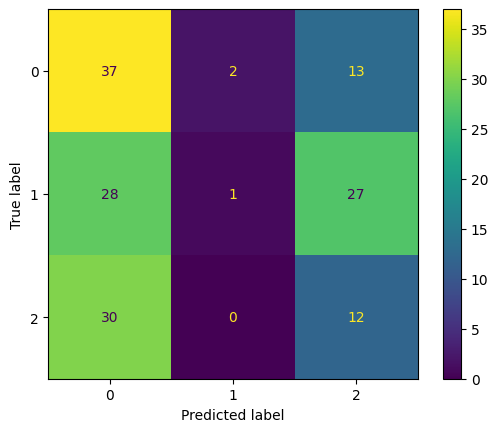

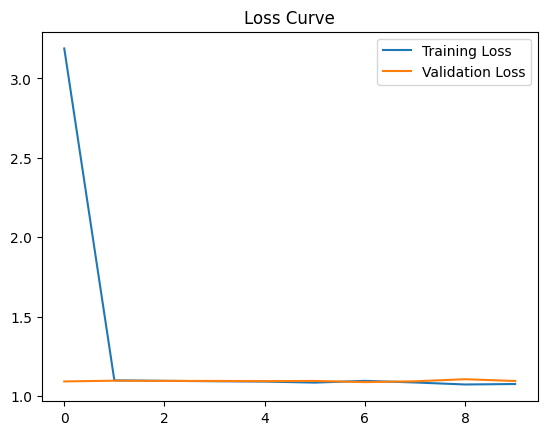

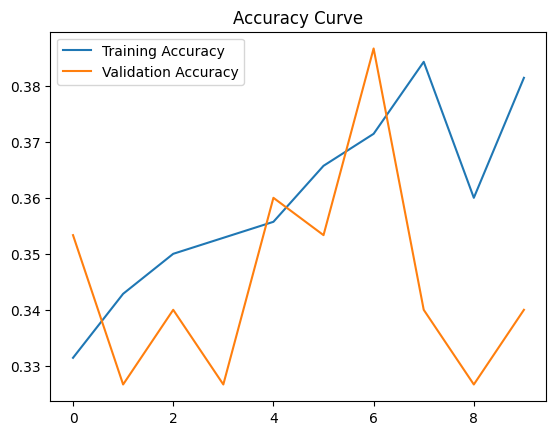

In [9]:
# **CNN Architecture**

# Reorder dimensions to match Keras expectations
X_train = np.moveaxis(X_train, 1, -1)  # Move the bands axis to the last position for training data
X_val = np.moveaxis(X_val, 1, -1)  # Move the bands axis for validation data
X_test = np.moveaxis(X_test, 1, -1)  # Move the bands axis for test data

print(f"Training data shape: {X_train.shape}")  # Log shape of training data
print(f"Validation data shape: {X_val.shape}")  # Log shape of validation data
print(f"Test data shape: {X_test.shape}")  # Log shape of test data

# Define the CNN model
model = tf.keras.Sequential([  # Sequential API for defining the model
    tf.keras.layers.Input(shape=(256, 256, 12)),  # Input layer for 256x256 patches with 12 bands
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer with 32 filters and ReLU activation
    tf.keras.layers.MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer with 64 filters
    tf.keras.layers.MaxPooling2D((2, 2)),  # Another max pooling layer
    tf.keras.layers.Flatten(),  # Flatten the output for the fully connected layers
    tf.keras.layers.Dense(64, activation='relu'),  # Fully connected layer with 64 neurons
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with softmax for 3 classes
])

# Compile the model
model.compile(optimizer='adam',  # Adam optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for multi-class classification
              metrics=['accuracy'])  # Track accuracy during training and validation

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))  # Train for 10 epochs with validation data

# Evaluate the CNN model
test_loss, test_accuracy = model.evaluate(X_test, y_test)  # Evaluate on the test set
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")  # Log test loss and accuracy

# Confusion matrix for CNN
predictions = model.predict(X_test)  # Generate predictions for the test data
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to predicted classes
cm = confusion_matrix(y_test, predicted_classes)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])  # Initialize display
disp.plot(cmap='viridis')  # Plot confusion matrix with color map
plt.show()  # Display the plot

# Plot training history: Loss curve
plt.figure()  # Create a new figure for the loss curve
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.legend()  # Add legend
plt.title('Loss Curve')  # Add title
plt.show()  # Display the plot

# Plot training history: Accuracy curve
plt.figure()  # Create a new figure for the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.legend()  # Add legend
plt.title('Accuracy Curve')  # Add title
plt.show()  # Display the plot

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 890ms/step - accuracy: 0.3047 - loss: 1.1554 - val_accuracy: 0.3000 - val_loss: 1.1621
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.3110 - loss: 1.1582 - val_accuracy: 0.3000 - val_loss: 1.1432
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3197 - loss: 1.1312 - val_accuracy: 0.3000 - val_loss: 1.1298
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3054 - loss: 1.1279 - val_accuracy: 0.3000 - val_loss: 1.1196
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3248 - loss: 1.1153 - val_accuracy: 0.3000 - val_loss: 1.1127
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3095 - loss: 1.1084 - val_accuracy: 0.3000 - val_loss: 1.1078
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3047 - loss: 1.1063 - val_accuracy: 0.3000 - val_loss: 1.1043
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3279 - loss: 1.1017 - val_accuracy: 0

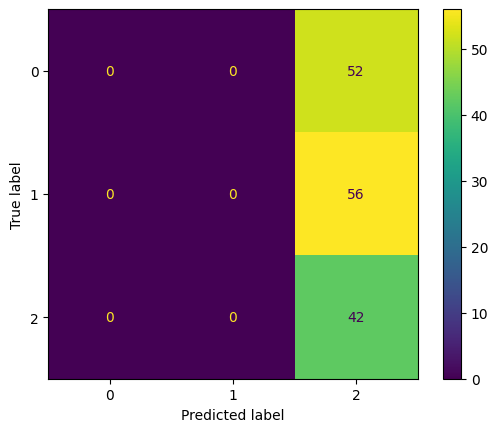

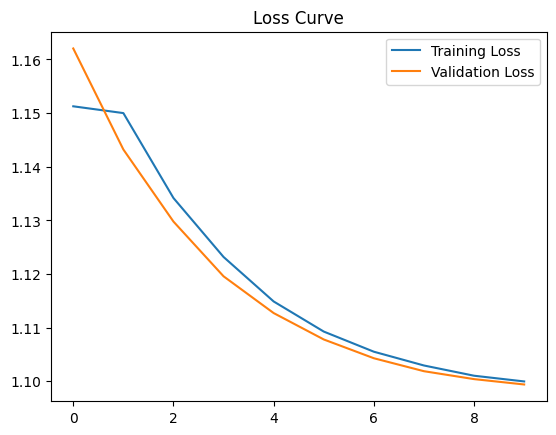

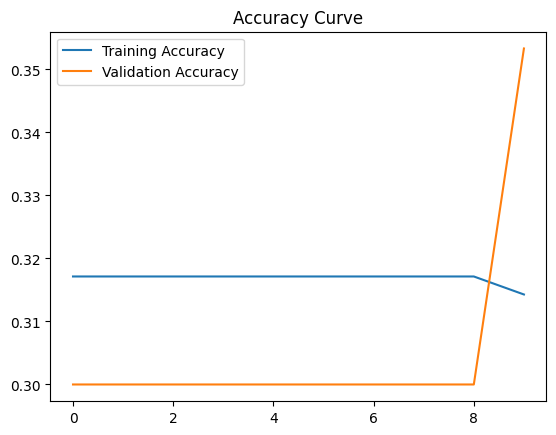

In [10]:
# ***U-Net Architecture***

from tensorflow.keras.models import Model  # U-Net model

# Build the U-Net for Classification
def build_unet_for_classification(input_shape, num_classes):
    inputs = Input(shape=input_shape)  # Input layer for U-Net

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # First convolution block
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)  # Down-sampling

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)  # Second convolution block
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)  # Down-sampling

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)  # Third convolution block
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)  # Down-sampling

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)  # Fourth convolution block
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)  # Down sampling

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)  # Bottleneck layer
    c5 = Dropout(0.5)(c5)  # Dropout for regularization
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)  # Second convolution in bottleneck

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)  # Up-sampling
    u6 = concatenate([u6, c4])  # Skip connection
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)  # Decoder convolution block
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Classification output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # Per-pixel softmax
    outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)  # Pool to a single vector per image
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(outputs)  # Final class prediction

    model = Model(inputs, outputs)  # Combine inputs and outputs into the U-Net model
    return model

# Build the U-Net model for classification
input_shape = (256, 256, 12)  # Define input shape: 256x256 patches with 12 bands
num_classes = 3  # Define number of output classes
unet_model = build_unet_for_classification(input_shape, num_classes) # Build the model

# Compile the model
unet_model.compile(optimizer='adam',  # Adam optimizer
                   loss='sparse_categorical_crossentropy',  # Loss function for multi-class segmentation
                   metrics=['accuracy'])  # Track accuracy

# Train the model
history = unet_model.fit(
    X_train, y_train,  # Training data and labels
    epochs=10,  # Train for 10 epochs
    validation_data=(X_val, y_val),  # Validation data and labels
    batch_size=16  # Use a batch size of 16
)

# Evaluate the model
test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)  # Evaluate on the test set
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")  # Lost test loss and accuracy

# Generate predictions using the U-Net model
predictions = unet_model.predict(X_test)  # Generate predictions on the test data
predicted_classes = np.argmax(predictions, axis=-1)  # Convert probabilities to predicted classes for segmentation

# Aggregate predictions per image
aggregated_predictions = np.array([np.bincount(p.ravel(), minlength=3).argmax() for p in predicted_classes])  # Majority class
aggregated_labels = y_test.flatten()  # Use the existing test labels for evaluation

# Confusion matrix for classification
cm = confusion_matrix(aggregated_labels, aggregated_predictions)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])  # Initialize display
disp.plot(cmap='viridis')  # Plot confusion matrix with color map
plt.show()  # Display the plot

# Plot training history: Loss curve
plt.figure()  # Create a new figure for the loss curve
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.legend()  # Add legend
plt.title('Loss Curve')  # Add title
plt.show()  # Display the plot

# Plot training history: Accuracy curve
plt.figure()  # Create a new figure for the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.legend()  # Add legend
plt.title('Accuracy Curve')  # Add title
plt.show()  # Display the plot

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Paired t-test results:
Logistic Regression vs. CNN: p-value = 0.4751297412530445
Logistic Regression vs. U-Net: p-value = 0.09436847882854395
CNN vs. U-Net: p-value = 0.3336427616405029


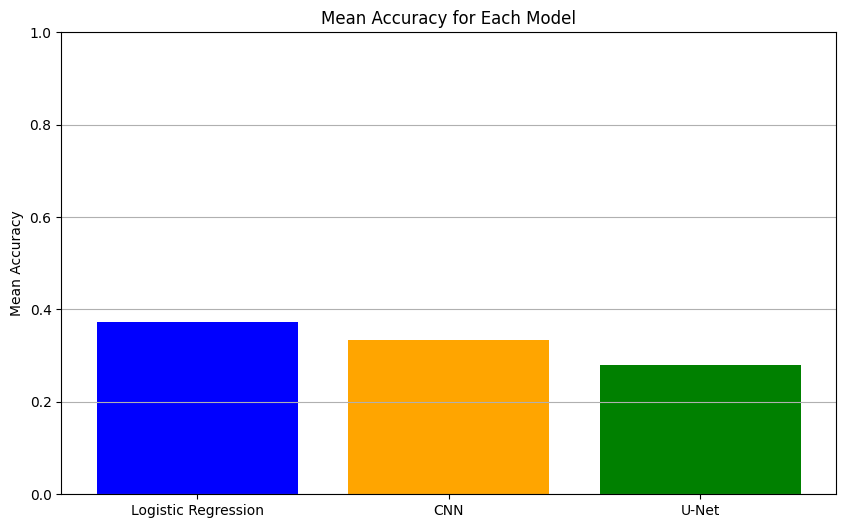

In [12]:
"""
# Model Comparison and Statistical Analysis
This code computes per-sample accuracy for Logistic Regression, CNN, and U-Net models,
performs paired t-tests for statistical significance, and visualizes the results.
"""

import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# --- Logistic Regression ---
logistic_sample_accuracy = (y_test == y_pred).astype(int)  # Per-sample accuracy (1 if correct, 0 otherwise)

# --- CNN ---
cnn_predictions = model.predict(X_test)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)
cnn_sample_accuracy = (y_test == cnn_predicted_classes).astype(int)

# --- U-Net ---
unet_predictions = unet_model.predict(X_test)
unet_predicted_classes = np.argmax(unet_predictions, axis=-1)
aggregated_predictions = np.array([np.bincount(p.ravel(), minlength=3).argmax() for p in unet_predicted_classes])
unet_sample_accuracy = (y_test == aggregated_predictions).astype(int)

# --- Combine Results ---
combined_results = pd.DataFrame({
    'True Label': y_test,
    'Logistic Accuracy': logistic_sample_accuracy,
    'CNN Accuracy': cnn_sample_accuracy,
    'U-Net Accuracy': unet_sample_accuracy
})

# Perform paired t-tests
logistic_vs_cnn_ttest = ttest_rel(logistic_sample_accuracy, cnn_sample_accuracy)
logistic_vs_unet_ttest = ttest_rel(logistic_sample_accuracy, unet_sample_accuracy)
cnn_vs_unet_ttest = ttest_rel(cnn_sample_accuracy, unet_sample_accuracy)

# Display p-values
print("Paired t-test results:")
print(f"Logistic Regression vs. CNN: p-value = {logistic_vs_cnn_ttest.pvalue}")
print(f"Logistic Regression vs. U-Net: p-value = {logistic_vs_unet_ttest.pvalue}")
print(f"CNN vs. U-Net: p-value = {cnn_vs_unet_ttest.pvalue}")

# Bar chart for mean accuracies
mean_accuracies = [
    logistic_sample_accuracy.mean(),
    cnn_sample_accuracy.mean(),
    unet_sample_accuracy.mean()
]

plt.figure(figsize=(10, 6))
plt.bar(
    ["Logistic Regression", "CNN", "U-Net"],
    mean_accuracies,
    color=['blue', 'orange', 'green']
)
plt.title("Mean Accuracy for Each Model")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()